In [1]:
import numpy as np
import mne

from hdf5storage import loadmat, savemat 
from mne.minimum_norm import make_inverse_operator, apply_inverse, compute_source_psd_epochs, write_inverse_operator

from matplotlib import pyplot as plt


In [2]:
outdict=loadmat('preprocessed_eeg.mat')
outdict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'ch_bad', 'ch_dubious', 'ch_labels', 'chanlocs', 'preprocessed_eeg', 'subject_ID'])

In [3]:
preprocessed_eeg=outdict['preprocessed_eeg']*0.000001 # reduce the amplitube to be shown on MNE's plot
sampling_freq=outdict['Fs'][0]
ch_bad=outdict['ch_bad'][0]-1
ch_dubious=outdict['ch_dubious'][0]-1
subject_ID=outdict['subject_ID'][0]

n_channels=np.shape(preprocessed_eeg)[0]
ch_info_bads=np.concatenate((ch_bad, ch_dubious), axis=0)
ch_info_bads=np.unique(ch_info_bads)

In [4]:
ch_names = [f"E{n}" for n in range(1, 257)]
ch_types = ["eeg"] * n_channels
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage("GSN-HydroCel-256",match_case=False,match_alias=False,on_missing='raise')
info["description"] = subject_ID
print(info)

<Info | 9 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 256 EEG
 custom_ref_applied: False
 description: ESCH
 dig: 259 items (3 Cardinal, 256 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 256
 projs: []
 sfreq: 1000.0 Hz
>


In [5]:
outdict=loadmat('./egi_xyz.mat')
Coordinates=outdict['Coordianates']/1000
for ch in range(3,len(info['dig'])):
    info['dig'][ch]['r']=Coordinates[ch-3,:]

In [6]:
# mark the bad channels
ch_labels_info_bads=list()
for k in range(len(ch_info_bads)):
    ch_labels_info_bads.append(ch_names[ch_info_bads[k]])

info['bads'] = ch_labels_info_bads

In [7]:
raw = mne.io.RawArray(preprocessed_eeg, info)
raw.set_eeg_reference('average', projection=True)
# raw.plot(show_scrollbars=False, show_scalebars=False)

Creating RawArray with float64 data, n_channels=256, n_times=180000
    Range : 0 ... 179999 =      0.000 ...   179.999 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<RawArray | 256 x 180000 (180.0 s), ~351.9 MB, data loaded>

In [8]:
raw.save("raw.fif",overwrite=True)

Overwriting existing file.
Writing /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_ESCH/raw.fif
Closing /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_ESCH/raw.fif
[done]


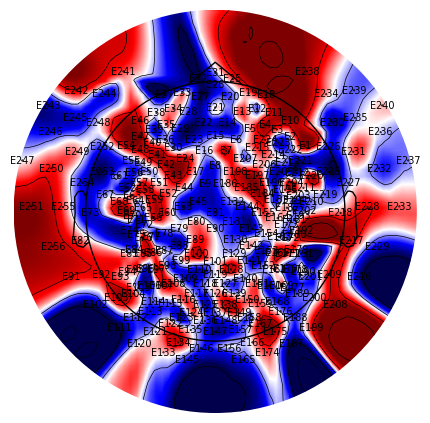

(<matplotlib.image.AxesImage at 0x7f016b0c58d0>,
 <matplotlib.contour.QuadContourSet at 0x7f016b0c5b70>)

In [8]:
# topoplot
import numpy as np
x=np.random.rand(256)
x=list(x*100)
# x=list(range(1,33,1))
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(x, \
    raw.info, vlim=(None, None), axes=ax,\
        sensors=True, names=ch_names, cmap='seismic')

forward solution

In [9]:
# the raw file containing the channel location + types
raw_fname = './raw.fif'

# The paths to Freesurfer reconstructions
subjects_dir ='../../archive/subjects/'
subject = 'fsaverage' # change it to use freesurfer's bem

# Compute Source Space (surface)
ico = 2 #**************************************************************
spacing='ico'+str(ico) 
src = mne.setup_source_space(subject, spacing=spacing, add_dist='patch',
                             subjects_dir=subjects_dir)

conductivity = (0.3, 0.0075, 0.3)  #  three layers for EEG (MNE default  (0.3 0.006 0.3) )
model = mne.make_bem_model(subject=subject, ico=ico,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

trans = './egi_trans.fif'

fwd = mne.make_forward_solution(raw_fname, trans=trans, src=src, bem=bem,
                                meg=False, eeg=True, mindist=5.0, n_jobs=2,
                                verbose=True)
print(fwd)


Setting up the source space with the following parameters:

SUBJECTS_DIR = /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_ESCH/../../archive/subjects
Subject      = fsaverage
Surface      = white
Icosahedron subdivision grade 2

>>> 1. Creating the source space...

Doing the icosahedral vertex picking...
Loading /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_ESCH/../../archive/subjects/fsaverage/surf/lh.white...
Mapping lh fsaverage -> ico (2) ...
    Triangle neighbors and vertex normals...
Loading geometry from /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_ESCH/../../archive/subjects/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 162/163842 selected to source space (ico = 2)

Loading /home/zhibinz2/Documents/GitHub/MEG_EEG_Source_Localization/EEG_spacing_ESCH/../../archive/subjects/fsaverage/surf/rh.white...
Mapping rh fsaverage -> ico (2) ...
    Triangl

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    Found   0/122 points outside using solid angles
    Total 162/162 points inside the surface
Interior check completed in 15751.3 ms
Checking surface interior status for 162 points...
    Found  38/162 points inside  an interior sphere of radius   48.9 mm
    Found   0/162 points outside an exterior sphere of radius   97.8 mm
    Found   0/124 points outside using surface Qhull
    Found   0/124 points outside using solid angles
    Total 162/162 points inside the surface
Interior check completed in 27.2 ms

Setting up for EEG...


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   15.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


Computing EEG at 324 source locations (free orientations)...

Finished.
<Forward | MEG channels: 0 | EEG channels: 256 | Source space: Surface with 324 vertices | Source orientation: Free>


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished


In [10]:
src

<SourceSpaces: [<surface (lh), n_vertices=163842, n_used=162>, <surface (rh), n_vertices=163842, n_used=162>] MRI (surface RAS) coords, subject 'fsaverage', ~30.1 MB>

In [ ]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,
                                         use_cps=True)
leadfield = fwd_fixed['sol']['data']
source_rr=fwd_fixed['source_rr']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

In [ ]:
mne.write_forward_solution('fwd.fif', fwd_fixed, overwrite=True, verbose=None)

inv

In [ ]:
# use the entire data as empty room noise
noise_cov = mne.compute_raw_covariance(raw)
noise_cov_mat=noise_cov['data']# it only included the good chans
# compute the average of the diagonal
# construct the scale of the noise cov
# scale=0.05 # 1% 5% 10% 30% 50% *******************************************************************************
scale_ave=np.mean(noise_cov_mat.diagonal())*scale
sim_cov_mat=np.zeros((np.shape(noise_cov_mat)))
for i in range(np.shape(sim_cov_mat)[0]):
       sim_cov_mat[i,i]=scale_ave


In [ ]:
# plt.imshow(noise_cov_mat,vmin=-1.5e-10, vmax=1.5e-10, cmap='jet')
# plt.colorbar()
# np.mean(noise_cov_mat.diagonal())

In [ ]:
sim_cov=noise_cov.copy()
sim_cov['data']=sim_cov_mat
# mne.write_cov('sim_cov.fif', sim_cov, overwrite=True, verbose=None)

In [ ]:
nepochs=int(np.floor(np.shape(preprocessed_eeg)[1]/sampling_freq))
epochs_mat = np.column_stack(
    (
        np.arange(0, np.shape(preprocessed_eeg)[1], sampling_freq),
        np.zeros(nepochs, dtype=int),
        np.array([1]*nepochs),
    )
)

epoch_dict = dict(resting=1)
epochs = mne.Epochs(raw, epochs_mat, tmin=0, tmax=0.999, event_id=epoch_dict, preload=True, baseline=(None, None))

evoked = epochs["resting"].average()
mne.write_evokeds('resting_ave.fif', evoked, on_mismatch='raise', overwrite=True, verbose=None)
evokeds = mne.read_evokeds('./resting_ave.fif')
resting = evokeds[0]

In [ ]:
# fwd = mne.read_forward_solution('fwd.fif')
mne.convert_forward_solution(fwd, surf_ori=True, copy=False)

In [ ]:
# Compute the source estimate (Fixed dipole orientations)
# depth=0.8 # 0.8 1 2 4 ***************************************************************************************
inverse_operator = make_inverse_operator(resting.info, fwd, sim_cov, depth=depth, fixed=True)
# save the inverse operator and the inverse matrix
# write_inverse_operator('inv.fif', inverse_operator,overwrite=True)

In [ ]:
%run extract_invmat.ipynb # run this script to load the functions needed to extract inverse matrix

In [ ]:
method = "MNE"  # (could also be dSPM or sLORETA)
invmat=_get_matrix_from_inverse_operator(inverse_operator,fwd,method=method,lambda2=1.0/9.0)
np.shape(invmat)

Correlation

In [ ]:
# remove bad channels from the original eeg
original_eeg=np.delete(preprocessed_eeg,ch_info_bads,0)

In [ ]:
# reconstruct eeg using invmat and leadfield matrix
source_data=np.matmul(invmat,original_eeg)
EEG_recon=np.matmul(leadfield,source_data)

In [ ]:
# remove bad channels from the reconstructed eeg
EEG_recon=np.delete(EEG_recon,ch_info_bads,0)

In [ ]:
# plt.plot(np.arange(0,np.shape(EEG_recon)[1],1),EEG_recon.transpose())
# plt.title('reconstructed EEG - all chan')
# plt.ylim([-2e-5,2e-5])
# # 16 s

In [ ]:
# plt.plot(np.arange(0,np.shape(EEG_recon)[1],1),EEG_recon[ch_dubious,:].transpose())
# plt.title('reconstructed EEG - dubious chan')
# plt.ylim([-2e-5,2e-5])

In [ ]:
# plt.plot(np.arange(0,np.shape(EEG_recon)[1],1),EEG_recon[ch_bad,:].transpose())
# plt.title('reconstructed EEG - bad chan')
# plt.ylim([-2e-5,2e-5])

In [ ]:
# compute correlation
corr = np.corrcoef(EEG_recon, original_eeg, rowvar=True)

In [ ]:
# np.arange(0,np.shape(EEG_recon)[0],1)+194

In [ ]:
# corr=corr[np.arange(0,np.shape(EEG_recon)[0],1)]

In [ ]:
# np.shape(corr)

In [ ]:
# corr=corr[:,np.arange(194,388,1)]

In [ ]:
# plt.imshow(corr,cmap='jet',vmin=-1,vmax=1)
# plt.ylabel('reconstructed EEG (194 good channels)')
# plt.xlabel('original EEG (194 good channels)')
# plt.title('correlation')
# plt.colorbar()

In [ ]:
plt.imshow(corr,cmap='jet',vmin=-1,vmax=1)
plt.colorbar()
plt.title('corrceof: ico' + str(ico) + ' scale ' +str(scale) +' depth '+ str(depth))

In [ ]:
corrcoef_diag=np.zeros((np.shape(EEG_recon)[0]))
for i in range(np.shape(EEG_recon)[0]):
    corrcoef_diag[i]=corr[i,np.shape(EEG_recon)[0]+i]
plt.plot(np.arange(0, np.shape(EEG_recon)[0],1) ,corrcoef_diag, 'r.')
plt.title('corrceof: ico' + str(ico) + ' scale ' +str(scale) +' depth '+ str(depth))
plt.xlabel('good channels')
plt.ylabel('corrcoef')

In [ ]:
# # save outputs all in one mat file. 
# outdict=dict()
# outdict['leadfield']=leadfield # leadfield matrix
# outdict['invmat']=invmat #  inverse matrix
# outdict['source_rr']=source_rr # the source location AND labels (matlab)
# outdict['sim_cov_mat']=sim_cov_mat # noise covariance
# outdict['scale']=scale # scale
# outdict['depth']=depth # depth
# outdict['conductivity']=conductivity # 3 layrs conductivity


# outdict['ch_bad']=ch_bad #  inverse matrix
# outdict['ch_dubious']=ch_dubious # 
# outdict['ch_names']=ch_names #  
# outdict['Coordinates']=Coordinates #  
# outdict['corrcoef_diag']=corrcoef_diag #  
# outdict['subject_ID']=subject_ID #  

# savemat(subject_ID+'_scale_'+str(scale)+'_depth_'+str(depth),outdict)